# Training with Attribution Priors in TF 2.0 + tf.keras
This notebook is an example notebook for how to train with attribution priors using the eager execution and TensorFlow 2.0 and above, as well as the tf.keras API for model-building. It trains a simple model on MNIST that penalizes the total variation between neighboring pixels.

In [1]:
import tensorflow as tf
import numpy as np
import shap
import pandas as pd
import altair as alt
import time
import scipy.stats as stats
from attributionpriors import eager_ops

In [2]:
# Strictly speaking, this line isn't necessary, because eager 
# execution is enabled by default.
tf.compat.v1.enable_eager_execution()

## Model Building
Here we build a `tf.keras` model using the standard `tf.keras.layers` API. The network is a simple network with two convolutional layers and a single dense layer.

In [3]:
model = tf.keras.models.Sequential()
    
model.add(tf.keras.layers.Input(shape=(28, 28, 1), dtype=tf.float32))
model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same'))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same'))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024))
model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10))
model.add(tf.keras.layers.Activation('softmax'))

## Data Reading
We will read the data in through the `tf.keras.datasets` API, which downloads the data if you don't already haven't on disk. We will normalize the images by setting them in the range [-0.5, 0.5]. This is not necessarily optimal, but it is simple and serves the purpose of this notebook. We also set the labels to be one-hot encoded, which makes for easy training with a cross-entropy loss function.

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()    
x_train = np.expand_dims(x_train.astype('float32'), axis=-1)
x_test  = np.expand_dims(x_test.astype('float32'),  axis=-1)
x_train = x_train * (1. / 255) - 0.5
x_test  = x_test  * (1. / 255) - 0.5
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test  = tf.keras.utils.to_categorical(y_test,  10)

## Model Training
We optimize the model by manually defining the training step. We do this because it allows us to define creative loss functions on the attributions.

In [5]:
# These hyper-parameter values are not optimized. They
# are simply easy defaults for this example notebook.
lamb = 0.001
num_epochs = 10
batch_size = 50
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
loss_fn   = tf.keras.losses.CategoricalCrossentropy()
train_acc_fn = tf.keras.metrics.CategoricalAccuracy()
test_acc_fn  = tf.keras.metrics.CategoricalAccuracy()

In [6]:
@tf.function
def train_step(inputs, labels):
    '''
    Takes a single step of training. 

    Args:
        inputs: A tensor. A batch of input to the model.
        labels: A tensor. The labels to use when training.
        model: A tf.keras.Model object, or subclass thereof.
    Returns:
        The predictions of the model on the inputs. Useful if you need to update metrics after training.
    '''
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        predictions = model(inputs, training=True)
        pred_loss = loss_fn(labels, predictions)
        total_loss = pred_loss

        if len(model.losses) > 0:
            regularization_loss = tf.math.add_n(model.losses)
            total_loss = total_loss + regularization_loss

        ######## Training with attributions ########
        # The code below uses the eager_ops API to compute the expected gradients
        # of the model predictions with respect to the true class. See
        # eager_ops.py for more.
        
        # Get the attributions of the model
        attributions        = eager_ops.expected_gradients(inputs, labels, model)
        
        # Define a loss function on top of the attributions. Here we use
        # total variation of normalized attributions between neighboring pixels.
        
        # Sum across color channels (in this case there is only one)
        summed_attributions = tf.reduce_sum(attributions, axis=-1, keepdims=True)
        
        # Normalize attributions. Otherwise, we could set total variation arbitrarily
        # low by lowering the magnitude of the attributions.
        normalized_attributions = tf.image.per_image_standardization(summed_attributions)
        
        # Get the total variation.
        attribution_loss    = lamb * tf.reduce_mean(tf.image.total_variation(normalized_attributions))
        total_loss          = total_loss + attribution_loss
        ############################################

    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return predictions

In [7]:
start_time = time.time()
for epoch in range(num_epochs):
    indices = np.random.permutation(len(x_train))
    
    for i in range(0, len(x_train), batch_size):
        x_batch_train = x_train[indices[i:min(i + batch_size, len(x_train))]]
        y_batch_train = y_train[indices[i:min(i + batch_size, len(y_train))]]
        predictions = train_step(x_batch_train, y_batch_train)
        train_acc_fn(y_batch_train, predictions)
    train_acc = train_acc_fn.result().numpy()
    
    print('Epoch {} - train_accuracy: {:.4f} ({:.1f} seconds / epoch)'.format(epoch + 1, 
                                                                          train_acc, 
                                                                          time.time() - start_time))
    start_time = time.time()
        
    train_acc_fn.reset_states()

W1031 10:17:28.881561 139967677081408 deprecation.py:323] From /home/psturm/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/ops/image_ops_impl.py:1518: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
W1031 10:17:28.939445 139967677081408 deprecation.py:323] From /home/psturm/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/ops/math_grad.py:1394: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1 - train_accuracy: 0.9225 (10.9 seconds / epoch)
Epoch 2 - train_accuracy: 0.9754 (8.5 seconds / epoch)
Epoch 3 - train_accuracy: 0.9814 (8.4 seconds / epoch)
Epoch 4 - train_accuracy: 0.9827 (8.4 seconds / epoch)
Epoch 5 - train_accuracy: 0.9848 (8.5 seconds / epoch)
Epoch 6 - train_accuracy: 0.9862 (8.4 seconds / epoch)
Epoch 7 - train_accuracy: 0.9873 (8.4 seconds / epoch)
Epoch 8 - train_accuracy: 0.9877 (8.4 seconds / epoch)
Epoch 9 - train_accuracy: 0.9882 (8.4 seconds / epoch)
Epoch 10 - train_accuracy: 0.9886 (8.5 seconds / epoch)


In [8]:
for i in range(0, len(x_test), batch_size):
    x_batch_test = x_test[i:min(i + batch_size, len(x_test))]
    y_batch_test = y_test[i:min(i + batch_size, len(y_test))]
    test_logits = model(x_batch_test)
    test_acc_fn(y_batch_test, test_logits)
test_acc = test_acc_fn.result().numpy()

In [9]:
print('Final test accuracy: {:.4f}'.format(test_acc))

Final test accuracy: 0.9908


## Getting and displaying attributions on test data
Getting attributions at training time and at test time require two different functions. The training time function, `eager_ops.expected_gradients(inputs, labels, model)` assumes that you will use 1 background reference per sample and that background reference will be drawn from the same batch of inputs. The test time function, `eager_ops.expected_gradients_full(inputs, references, model, k, index_true_class, labels)` requires that you specify the references you draw from, as well as how many references you want to use (the k argument). 

In [13]:
def norm_zero_one(x, axis=(1,2,3), min=0.0, max=1.0):
    normed_x = (x - np.min(x, axis=axis, keepdims=True)) / (np.max(x, axis=axis, keepdims=True) - np.min(x, axis=axis, keepdims=True))
    return normed_x * (max - min) + min

In [14]:
test_images = x_test[:5]
test_inputs = tf.constant(test_images)
test_labels = y_test[:5]
test_labels_sparse = np.argmax(test_labels, axis=-1)

In [19]:
##### Generating test time attributions #####
eg_values = eager_ops.expected_gradients_full(test_inputs, x_train, model,
                                                k=100, index_true_class=True, labels=test_labels)

Notice that the attributions below look smooth! This is because we have trained them to have a low total variation.

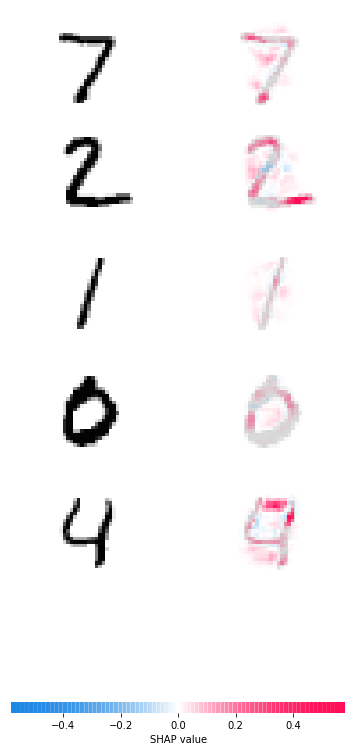

In [20]:
shap.image_plot(eg_values.numpy(), -norm_zero_one(test_images))

## Multi-class attributions
What if we want attributions across all classes, not just the true class? That's what the function `eager_ops.expected_gradients_multi_output(inputs, references, model, num_classes, k=100)` is for. This function explains the first `num_classes` classes of your output and returns an array of shape `(batch_size, num_classes, ...)` where ... represents the input dimensions.

In [39]:
num_classes = 10
eg_vals_multi_class = eager_ops.expected_gradients_multi_output(test_inputs, x_train, model, 
                                                                num_classes=num_classes, k=100)

In [ ]:
# Note: the SHAP plotting package expects a list of arrays of shape (batch_size, ...) where
# ... represents the input dimensionality, and the list entries represent one
# array per output class. In order to convert our returned array to that form, we
# split along axis=1, which represents the output class dimension.

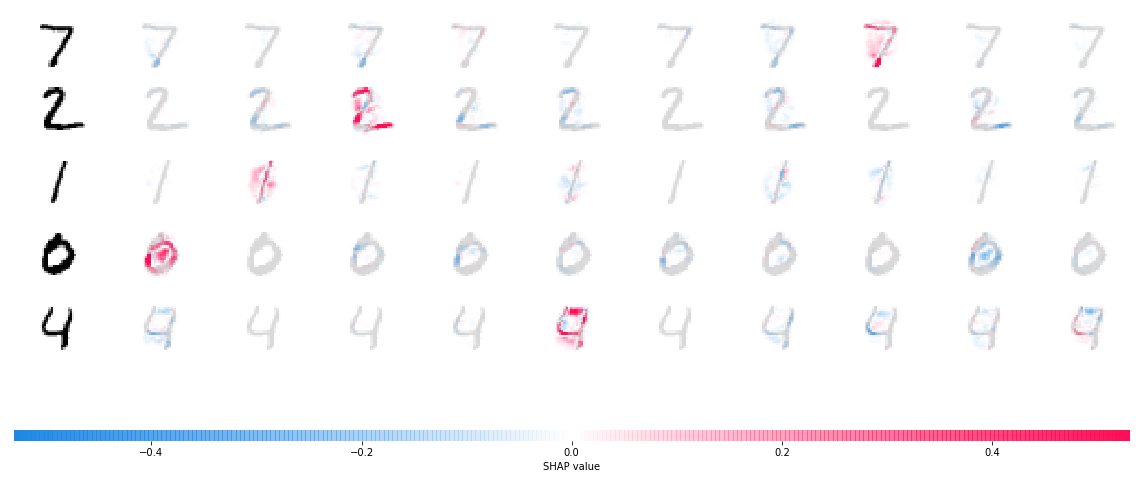

In [40]:
shap.image_plot([np.squeeze(arr, axis=1) for arr in np.split(eg_vals_multi_class.numpy(), num_classes, axis=1)], 
                -norm_zero_one(test_images))